<h1>I. Import libraries </h1>

In [192]:
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
import math
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
import seaborn as sns


<h1> II. Define functions</h1>

Define the function to draw horizontal barplot

In [2]:
def draw_barplot_horizontal(name,value,fig_width=16,fig_height=20,title=''):
    fig, ax = plt.subplots(figsize =(fig_width, fig_height))

    # Horizontal Bar Plot
    ax.barh(name, value)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')


    ax.set_title(title,
                 loc ='left', )

    # Add Text watermark
    fig.text(0.9, 0.15,'MiBA_A10', fontsize = 12,
             color ='grey', ha ='right', va ='bottom',
             alpha = 0.7)

    # Show Plot
    plt.show()


Define cross_validation function, scoring method is R2 by default

In [3]:
def cross_validation_compas(compas_pipe, X_train, y_train,scoring='r2'):
    scores = cross_val_score(compas_pipe, X_train, y_train, cv = 5,scoring=scoring)
    return scores.mean()

Define the function to calculate the distance between two points

In [4]:

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return round(d,1)

<h1>III. Import dataset</h1>

Import dataset and have a basic look

In [5]:
listings = pd.DataFrame(pd.read_csv("./Dataset/listings.csv"))
listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,2.021120e+13,2021/12/8,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,...,4.90,4.71,4.29,HUTB-002062,t,19,19,0,0,0.21
1,23197,https://www.airbnb.com/rooms/23197,2.021120e+13,2021/12/8,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...","Strategically located in the Parc del Fòrum, a...",https://a0.muscache.com/pictures/miso/Hosting-...,90417,https://www.airbnb.com/users/show/90417,...,4.98,4.66,4.67,HUTB-005057,f,2,2,0,0,0.41
2,32711,https://www.airbnb.com/rooms/32711,2.021120e+13,2021/12/8,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,https://www.airbnb.com/users/show/135703,...,4.79,4.81,4.40,HUTB-001722,t,3,3,0,0,0.50
3,34981,https://www.airbnb.com/rooms/34981,2.021120e+13,2021/12/7,VIDRE HOME PLAZA REAL on LAS RAMBLAS,Spacious apartment for large families or group...,"Located in Ciutat Vella in the Gothic Quarter,...",https://a0.muscache.com/pictures/c4d1723c-e479...,73163,https://www.airbnb.com/users/show/73163,...,4.68,4.73,4.47,HUTB-001506,f,2,2,0,0,1.17
4,35318,https://www.airbnb.com/rooms/35318,2.021120e+13,2021/12/7,Luxury room with private bathroom and balcony,"Luxury Room with King Size bed, private bathro...",The Gothic Quarter of Barcelona. One of the ol...,https://a0.muscache.com/pictures/miso/Hosting-...,152070,https://www.airbnb.com/users/show/152070,...,4.83,4.81,4.68,NaN,t,1,0,1,0,1.89


<h1>IV. Data cleaning</h1>

In [6]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [7]:
keep_var = ['id', 'name', 'description',
       'neighborhood_overview', 
       'host_is_superhost','neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights',   'number_of_reviews','availability_365',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month']
listings_cleaned = listings.loc[:,keep_var]
listings_cleaned.shape

(15707, 29)

To see whether we have dupulicated rows

In [8]:
listings_cleaned.duplicated().sum()

0

To check missing variables

In [9]:
listings_cleaned.isnull().sum() 

id                                 0
name                              10
description                       92
neighborhood_overview           6519
host_is_superhost                 36
neighbourhood                   6519
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_text                    17
bedrooms                         593
beds                             697
amenities                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
availability_365                   0
review_scores_rating            4084
review_scores_accuracy          4232
review_scores_cleanliness       4230
review_scores_checkin           4236
review_scores_communication     4231
review_scores_location          4237
r

In [10]:
listings_cleaned.dropna(subset=['name','bathrooms_text', 'bedrooms', 'beds'], inplace=True)

In [11]:
listings_cleaned['neighborhood_overview'].fillna(value='', inplace=True)
listings_cleaned['neighbourhood'].fillna(value='', inplace=True)
listings_cleaned['description'].fillna(value='', inplace=True)

In [12]:
listings_cleaned['host_is_superhost'].fillna(value='f', inplace=True)

In [13]:
listings_cleaned['price']

0        $102.00
1        $220.00
2        $144.00
3        $214.00
4         $93.00
          ...   
15701     $48.00
15702     $47.00
15703     $53.00
15704     $53.00
15706     $54.00
Name: price, Length: 14446, dtype: object

In [14]:
listings_cleaned['price'] = listings_cleaned['price'].str.replace('$', '').str.replace(',', '').astype(float)
listings_cleaned['price']

0        102.0
1        220.0
2        144.0
3        214.0
4         93.0
         ...  
15701     48.0
15702     47.0
15703     53.0
15704     53.0
15706     54.0
Name: price, Length: 14446, dtype: float64

In [15]:
# listings_cleaned['bathrooms'] = listings_cleaned['bathrooms_text'].str.replace('$', '').str.replace(',', '').astype(float)
listings_cleaned['bathrooms'] = listings_cleaned['bathrooms_text'].str.extract('([0-9][.]*[0-9]*)').astype(float)
listings_cleaned['bathrooms'].fillna(0, inplace=True)
listings_cleaned.drop(columns = 'bathrooms_text', inplace=True)


In [16]:
listings_cleaned['price'].describe()

count    14446.000000
mean       100.585906
std        224.481976
min          8.000000
25%         40.000000
50%         70.000000
75%        111.000000
max       9999.000000
Name: price, dtype: float64

<AxesSubplot:>

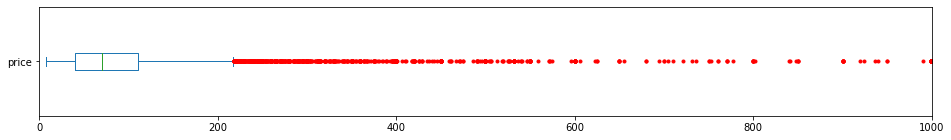

In [17]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings_cleaned['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2))

In [18]:
listings_cleaned.drop(listings_cleaned[ (listings_cleaned['price'] > 400) | (listings_cleaned['price'] <5) ].index, axis=0, inplace=True)


<AxesSubplot:>

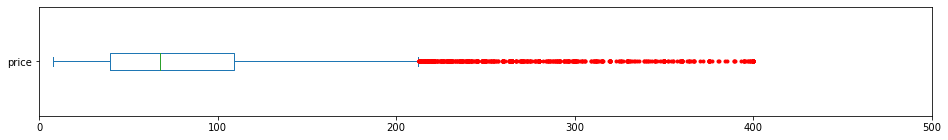

In [19]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings_cleaned['price'].plot(kind='box', xlim=(0, 500), vert=False, flierprops=red_square, figsize=(16,2))

In [20]:
neighbourhood = Counter(listings_cleaned['neighbourhood_cleansed'])
neighbourhood.most_common()

[("la Dreta de l'Eixample", 1702),
 ('el Raval', 1096),
 ('el Barri Gòtic', 922),
 ('la Sagrada Família', 910),
 ('Sant Pere, Santa Caterina i la Ribera', 834),
 ('la Vila de Gràcia', 821),
 ("l'Antiga Esquerra de l'Eixample", 800),
 ('el Poble Sec', 716),
 ('Sant Antoni', 708),
 ("la Nova Esquerra de l'Eixample", 516),
 ('el Fort Pienc', 413),
 ('el Poblenou', 344),
 ('la Barceloneta', 338),
 ('Sants', 300),
 ("el Camp de l'Arpa del Clot", 270),
 ("el Camp d'en Grassot i Gràcia Nova", 269),
 ('Sant Gervasi - Galvany', 261),
 ('Hostafrancs', 177),
 ('el Parc i la Llacuna del Poblenou', 175),
 ('el Putxet i el Farró', 173),
 ('Sants - Badal', 161),
 ('les Corts', 155),
 ('el Guinardó', 153),
 ('la Vila Olímpica del Poblenou', 134),
 ('Diagonal Mar i el Front Marítim del Poblenou', 125),
 ('el Baix Guinardó', 125),
 ('la Maternitat i Sant Ramon', 103),
 ('el Besòs i el Maresme', 99),
 ('Vallcarca i els Penitents', 90),
 ('la Font de la Guatlla', 89),
 ('el Carmel', 75),
 ('el Clot', 74),

In [21]:
listings_cleaned.drop(listings_cleaned[ (listings_cleaned['neighbourhood_cleansed'] == 'Canyelles') | (listings_cleaned['neighbourhood_cleansed'] == 'la Marina del Prat Vermell') | \
                                       (listings_cleaned['neighbourhood_cleansed'] == 'la Clota') | (listings_cleaned['neighbourhood_cleansed'] == 'Can Peguera') | \
                                       (listings_cleaned['neighbourhood_cleansed'] == 'Vallvidrera, el Tibidabo i les Planes') | (listings_cleaned['neighbourhood_cleansed'] == 'Ciutat Meridiana') ].index, axis=0, inplace=True)



In [22]:
neighbourhood_cleansed = listings_cleaned.groupby(by = 'neighbourhood_cleansed').mean()['price'].sort_values(ascending=False).to_dict()

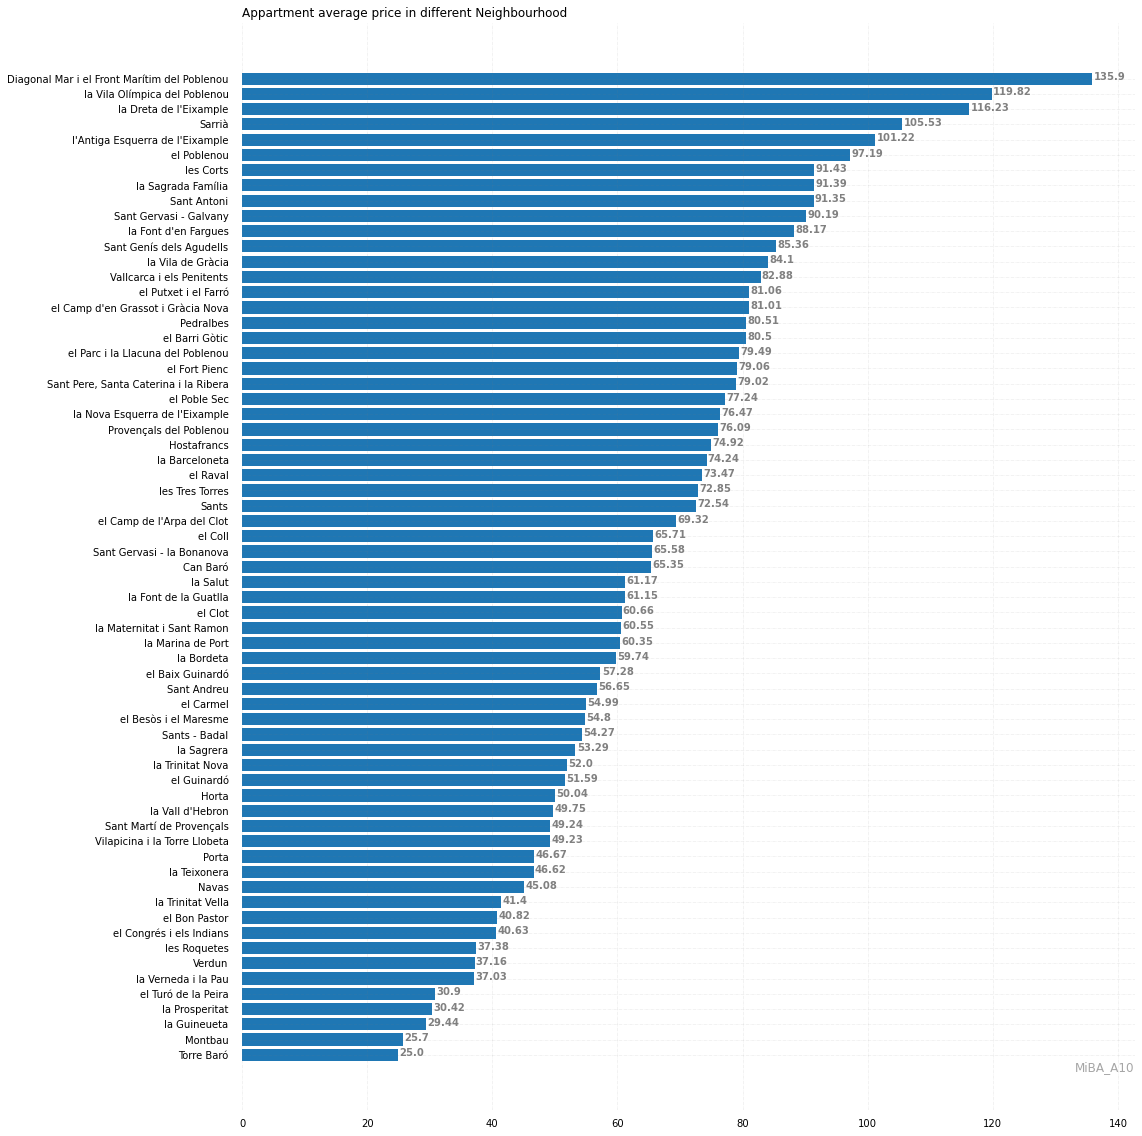

In [23]:
draw_barplot_horizontal(list(neighbourhood_cleansed.keys()), 
                        list(neighbourhood_cleansed.values()),
                        title='Appartment average price in different Neighbourhood')

In [24]:
listings_cleaned['property_type'].value_counts()

Entire rental unit                     6750
Private room in rental unit            4860
Entire serviced apartment               363
Entire condominium (condo)              244
Private room in condominium (condo)     207
Room in boutique hotel                  206
Room in hotel                           186
Private room in residential home        186
Entire loft                             174
Private room in hostel                  148
Shared room in rental unit               90
Shared room in hostel                    80
Private room in serviced apartment       73
Private room in guest suite              71
Private room in bed and breakfast        60
Entire residential home                  50
Private room in loft                     46
Room in hostel                           40
Entire guest suite                       37
Room in serviced apartment               29
Private room in casa particular          28
Boat                                     23
Entire guesthouse               

In [25]:
listings_cleaned.drop(listings_cleaned[ (listings_cleaned['property_type'] != 'Entire rental unit') & (listings_cleaned['property_type'] != 'Private room in rental unit') ].index, axis=0, inplace=True)
# listings_cleaned.drop(listings_cleaned[ (listings_cleaned['property_type'] != 'Entire rental unit') ].index, axis=0, inplace=True)

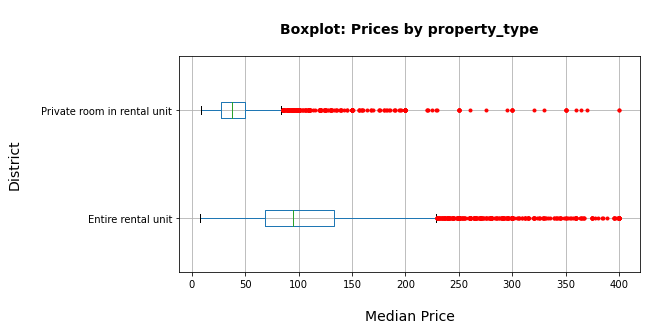

In [202]:
red_square = dict(markerfacecolor='red', markeredgecolor='red', marker='.')

listings_cleaned.boxplot(column='price', by='property_type', 
           flierprops=red_square, vert=False, figsize=(8,4))

plt.xlabel('\nMedian Price', fontsize=14)
plt.ylabel('District\n', fontsize=14)
plt.title('\nBoxplot: Prices by property_type\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

In [26]:
listings_cleaned['size'] = listings_cleaned['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
listings_cleaned['size'] = listings_cleaned['size'].str.replace("\D", "").astype(float)
listings_cleaned['size']

0        110.0
1          NaN
2        250.0
3        115.0
5          NaN
         ...  
15701     34.0
15702     30.0
15703     30.0
15704     30.0
15706     30.0
Name: size, Length: 11610, dtype: float64

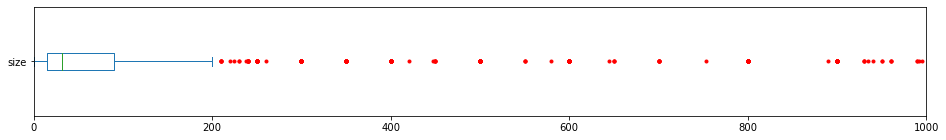

In [27]:
listings_cleaned['size'].describe()
listings_cleaned['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2))
listings_cleaned.drop(listings_cleaned[ (listings_cleaned['size'] > 150) | (listings_cleaned['size'] <5) ].index, axis=0, inplace=True)


<AxesSubplot:>

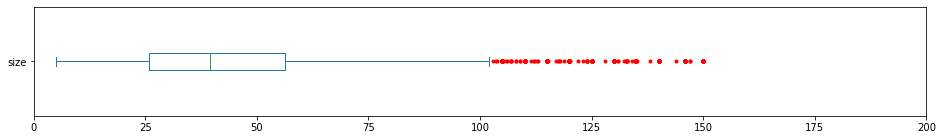

In [203]:
listings_cleaned['size'].plot(kind='box', xlim=(0, 200), vert=False, flierprops=red_square, figsize=(16,2))


In [29]:
listings_cleaned['accommodates'] = listings_cleaned['accommodates'].astype(float)

In [30]:
listings_cleaned.isnull().sum() 

id                                 0
name                               0
description                        0
neighborhood_overview              0
host_is_superhost                  0
neighbourhood                      0
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bedrooms                           0
beds                               0
amenities                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
availability_365                   0
review_scores_rating            2602
review_scores_accuracy          2708
review_scores_cleanliness       2706
review_scores_checkin           2710
review_scores_communication     2706
review_scores_location          2709
review_scores_value             2709
r

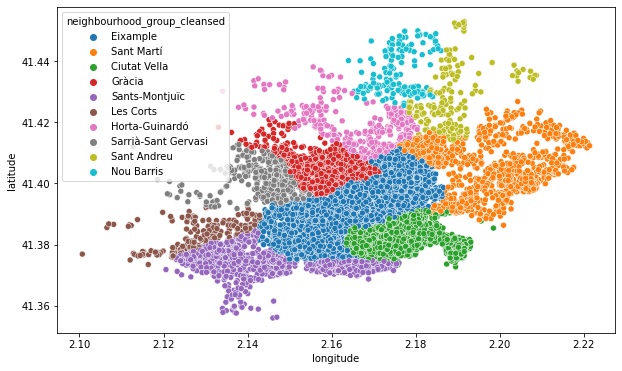

In [173]:
plt.figure(figsize=(10,6))
sns.scatterplot(listings_cleaned.longitude,listings_cleaned.latitude,hue=listings_cleaned.neighbourhood_group_cleansed)
plt.ioff()

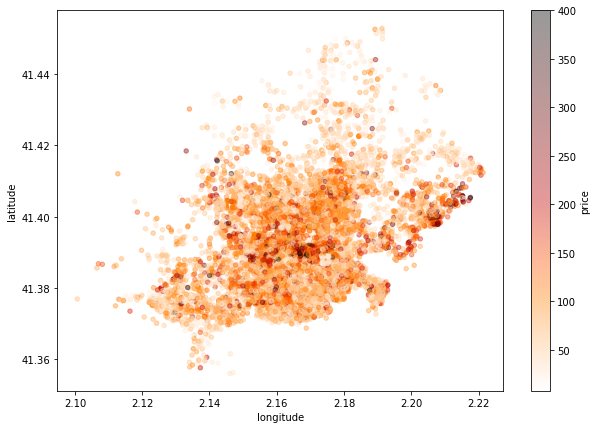

In [170]:
listings_cleaned.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

Index(['id', 'name', 'description', 'neighborhood_overview',
       'host_is_superhost', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'number_of_reviews',
       'availability_365', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'bathrooms', 'size',
       'distance', 'Hair dryer', 'Iron', 'Air conditioning', 'TV',
       'Coffee maker', 'Oven', 'Patio or balcony'],
      dtype='object')

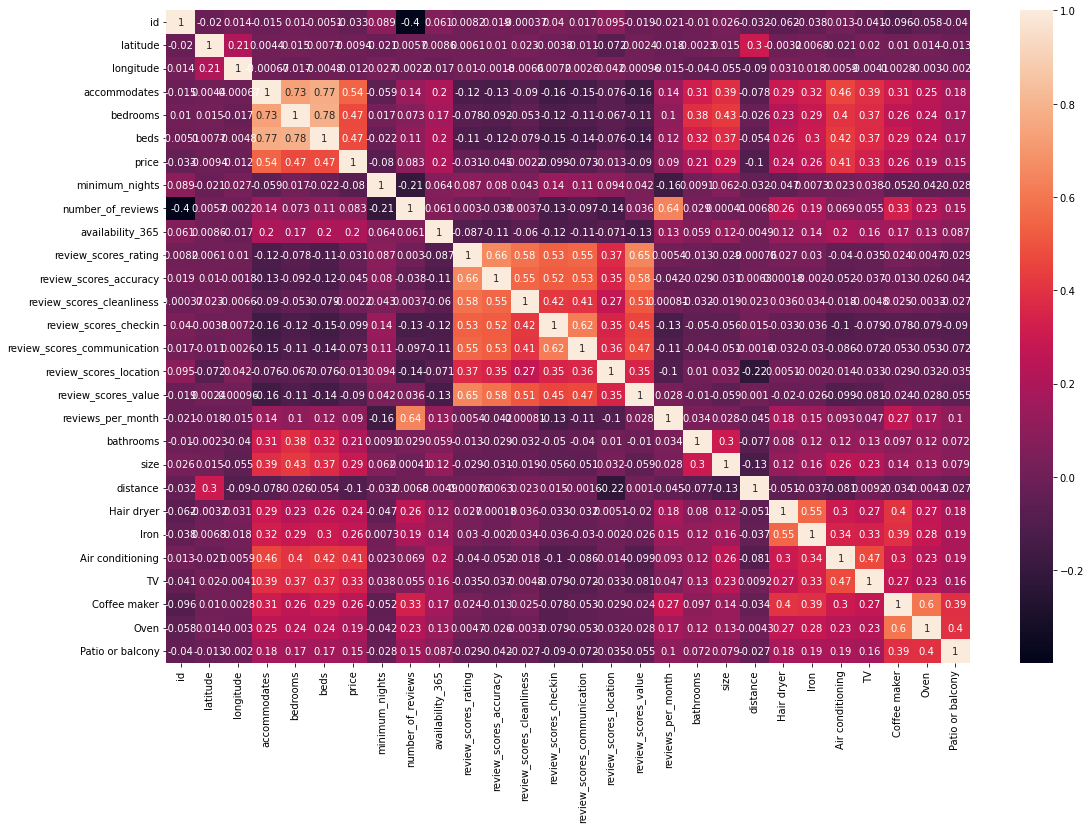

In [194]:
corr = listings_cleaned.corr(method='kendall')
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True)
listings_cleaned.columns

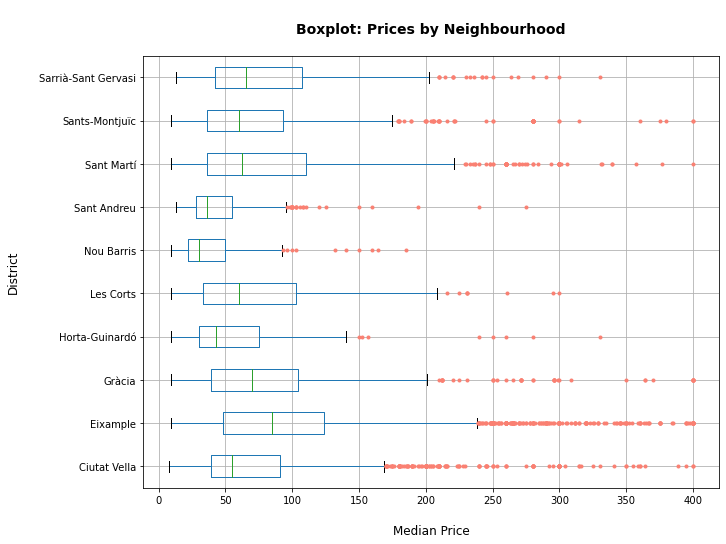

In [195]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

listings_cleaned.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

<h1>V. Data engineering</h1>

In [31]:
city_center = (41.3870154, 2.1700471)
listings_cleaned['distance'] = listings_cleaned.apply(lambda x: distance((x.latitude, x.longitude),city_center), axis=1)

In [32]:
listings_cleaned_size = listings_cleaned.loc[~listings_cleaned['size'].isnull(),['bedrooms','beds','bathrooms','accommodates','size','property_type','neighbourhood_group_cleansed','distance']]


In [33]:
listings_cleaned_size.isna().sum()

bedrooms                        0
beds                            0
bathrooms                       0
accommodates                    0
size                            0
property_type                   0
neighbourhood_group_cleansed    0
distance                        0
dtype: int64

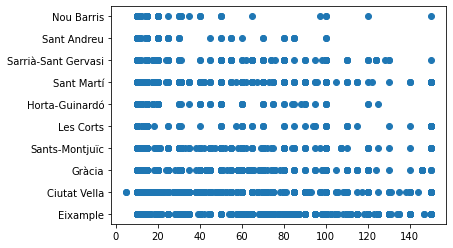

In [34]:
plt.scatter(listings_cleaned_size['size'],listings_cleaned_size['neighbourhood_group_cleansed'])

In [35]:
listings_cleaned['neighbourhood_group_cleansed'].value_counts()
# 'neighbourhood','neighbourhood_cleansed', 'neighbourhood_group_cleansed'

Eixample               3970
Ciutat Vella           2523
Sants-Montjuïc         1264
Sant Martí             1093
Gràcia                  977
Sarrià-Sant Gervasi     410
Horta-Guinardó          337
Les Corts               229
Sant Andreu             180
Nou Barris              151
Name: neighbourhood_group_cleansed, dtype: int64

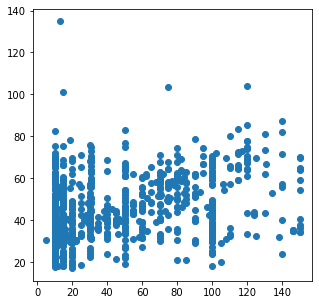

0.145814103894427

In [112]:
X = listings_cleaned_size.drop(columns='size')
y = listings_cleaned_size['size']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,train_size=0.8,test_size=0.2)
categorical_features = ['property_type','neighbourhood_group_cleansed']
transformer = ColumnTransformer([('ohe',OneHotEncoder(sparse=False),categorical_features)], remainder='passthrough')
pipeline_steps = [('preprocess', transformer),('scaler', StandardScaler()),('ml_model', LinearRegression())]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train,y_train)



y_pred = pipe.predict(X_test)


fig, ax = plt.subplots(figsize =(5, 5))
plt.scatter(y_test,y_pred)
plt.xlim=(0,200)
plt.ylim=(0,200)

plt.show()

cross_validation_compas(pipe,X_train,y_train,scoring='r2')




In [113]:
listings_cleaned.loc[listings_cleaned['size'].isna(),'size']
# listings_cleaned.loc[listings_cleaned['size'].isna(),].drop(columns='size')

Series([], Name: size, dtype: float64)

In [38]:
predict_size = pipe.predict(listings_cleaned.loc[listings_cleaned['size'].isnull(),['bedrooms','beds','bathrooms','accommodates','size','property_type','neighbourhood_group_cleansed','distance']])


In [39]:
listings_cleaned.loc[listings_cleaned['size'].isna(),'size'] = predict_size
listings_cleaned.drop(listings_cleaned[ (listings_cleaned['size'] > 200) | (listings_cleaned['size'] == 0) ].index, axis=0, inplace=True)


In [40]:
listings_cleaned['price'].quantile(0.5)

66.0

In [41]:
results_high_price = Counter()
listings_cleaned.loc[listings_cleaned['price']>=listings_cleaned['price'].quantile(0.5),'amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.replace('[', ' ')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results_high_price.update)
results_high_price.most_common(30)

[(' Wifi', 5391),
 (' Kitchen', 5261),
 (' Essentials', 5083),
 (' Hair dryer', 4939),
 (' Iron', 4927),
 (' Washer', 4864),
 (' Air conditioning', 4771),
 (' Heating', 4695),
 (' Hangers', 4554),
 (' Long term stays allowed]', 4439),
 (' TV', 4290),
 (' Coffee maker', 3774),
 (' Refrigerator', 3768),
 (' Elevator', 3726),
 (' Microwave', 3713),
 (' Hot water', 3669),
 (' Cooking basics', 3657),
 (' Dishes and silverware', 3464),
 (' Shampoo', 3341),
 (' Oven', 3125),
 (' Dedicated workspace', 3058),
 (' Bed linens', 2709),
 (' Stove', 2539),
 (' Dishwasher', 2459),
 (' Crib', 2332),
 (' Patio or balcony', 2082),
 (' Dryer', 1716),
 (' High chair', 1696),
 (' Smoke alarm', 1605),
 (' Host greets you', 1604)]

In [42]:
results_low_price = Counter()
listings_cleaned.loc[listings_cleaned['price']<listings_cleaned['price'].quantile(0.5),'amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.replace('[', ' ')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results_low_price.update)
results_low_price.most_common(30)

[(' Wifi', 5076),
 (' Essentials', 4896),
 (' Kitchen', 4856),
 (' Hangers', 4317),
 (' Washer', 3899),
 (' Heating', 3797),
 (' Long term stays allowed]', 3789),
 (' Hair dryer', 3652),
 (' Hot water', 3561),
 (' Iron', 3461),
 (' Shampoo', 2973),
 (' Dedicated workspace', 2866),
 (' TV', 2802),
 (' Elevator', 2748),
 (' Cooking basics', 2625),
 (' Refrigerator', 2599),
 (' Microwave', 2396),
 (' Dishes and silverware', 2360),
 (' Air conditioning', 2229),
 (' Coffee maker', 1978),
 (' Bed linens', 1868),
 (' Oven', 1828),
 (' Stove', 1744),
 (' Host greets you', 1631),
 (' First aid kit', 1467),
 (' Extra pillows and blankets', 1397),
 (' Lock on bedroom door', 1251),
 (' Patio or balcony', 1138),
 (' Luggage dropoff allowed', 1130),
 (' Paid parking off premises', 1005)]

In [43]:
results_high_price = pd.DataFrame(results_high_price.most_common(30), columns=['amenity', 'count_high_price']).sort_values(by=['count_high_price'], ascending=True)
results_low_price = pd.DataFrame(results_low_price.most_common(30), columns=['amenity', 'count_low_price'])
results_high_price['count_high_price'] = results_high_price['count_high_price']/sum(listings_cleaned['price']>=listings_cleaned['price'].quantile(0.5))
results_low_price['count_low_price'] = results_low_price['count_low_price']/sum(listings_cleaned['price']<listings_cleaned['price'].quantile(0.5))
results_merged_price = pd.DataFrame.merge(results_high_price,results_low_price,how='inner', on='amenity')
results_merged_price


,amenity,count_high_price,count_low_price
0,Host greets you,0.287765,0.293345
1,Patio or balcony,0.373520,0.204676
2,Stove,0.455508,0.313669
3,Bed linens,0.486006,0.335971
4,Dedicated workspace,0.548619,0.515468
5,Oven,0.560639,0.328777
6,Shampoo,0.599390,0.534712
7,Dishes and silverware,0.621457,0.424460
8,Cooking basics,0.656082,0.472122
9,Hot water,0.658235,0.640468


<AxesSubplot:title={'center':'Amenities'}, ylabel='amenity'>

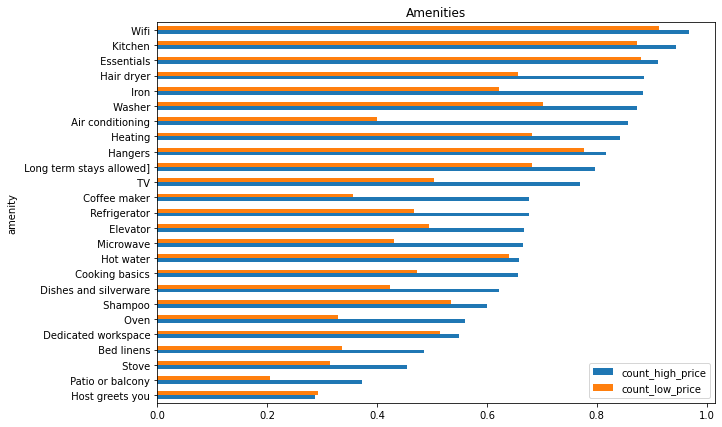

In [44]:
results_merged_price.plot(kind='barh', x='amenity',figsize=(10,7),legend=True,
                                                      title='Amenities')

In [45]:
listings_cleaned['Hair dryer'] = listings_cleaned['amenities'].str.contains('Hair dryer')
listings_cleaned['Iron'] = listings_cleaned['amenities'].str.contains('Iron')

listings_cleaned['Air conditioning'] = listings_cleaned['amenities'].str.contains('Air conditioning')

listings_cleaned['TV'] = listings_cleaned['amenities'].str.contains('TV')
listings_cleaned['Coffee maker'] = listings_cleaned['amenities'].str.contains('Coffee maker')
listings_cleaned['Oven'] = listings_cleaned['amenities'].str.contains('Oven')
listings_cleaned['Patio or balcony'] = listings_cleaned['amenities'].str.contains('Patio or balcony')


<h1>VI. Model Building<h1/>

In [46]:
# corr = listings_cleaned_final_prediction.corr(method='pearson')
# multicollinearity, V=np.linalg.eig(corr)
# multicollinearity

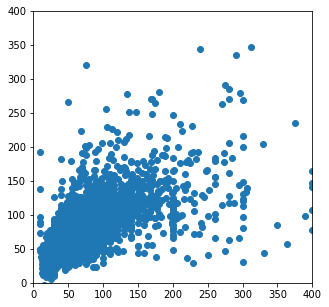

0.32332853597889794

In [92]:
variables = ['host_is_superhost',
        
       'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights',
       'number_of_reviews', 'availability_365',
       'bathrooms']

listings_cleaned_all_prediction = listings_cleaned[variables]
X = listings_cleaned_all_prediction.drop(columns='price')
y = listings_cleaned_all_prediction['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,test_size=0.2)
categorical_features = ['host_is_superhost',
       'property_type', 'room_type']
transformer = ColumnTransformer([('ohe',OneHotEncoder(sparse=False),categorical_features)], remainder='passthrough')
pipeline_steps = [('preprocess', transformer),('scaler', StandardScaler()),('ml_model', xgb.XGBRegressor())]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train,y_train)



y_pred = pipe.predict(X_test)


fig, ax = plt.subplots(figsize =(5, 5))
plt.scatter(y_test,y_pred)
ax.set_xlim(xmin=0.0, xmax=400)
ax.set_ylim(ymin=0.0, ymax=400)

plt.show()

cross_validation_compas(pipe,X,y,scoring='r2')


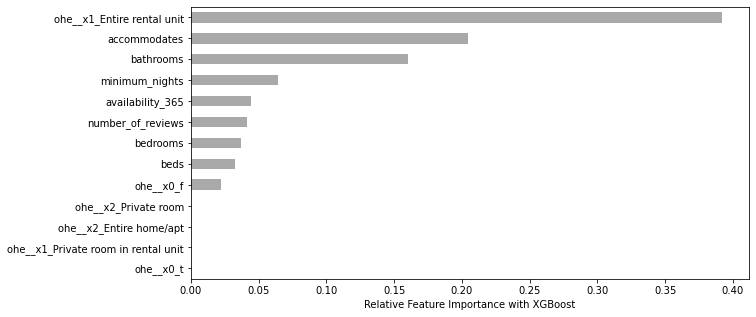

In [93]:

feat_importances = pd.Series(pipe.steps[2][1].feature_importances_, index=pipe.steps[0][1].get_feature_names())
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

In [120]:
variables_final_prediction = [ 
       'host_is_superhost','property_type',
        'accommodates','minimum_nights',
       'bathrooms', 'bedrooms', 'price','distance',
       'availability_365', 'Hair dryer','Iron','Air conditioning','TV','Coffee maker','Oven','Patio or balcony']
# variables_final_prediction = [ 
#        'host_is_superhost',
#        'neighbourhood_cleansed','property_type', 'room_type', 'accommodates',
#        'bathrooms', 'bedrooms', 'beds', 'size', 'price',
#        'availability_365', 'Hair dryer','Iron','Air conditioning','TV','Coffee maker','Oven','Patio or balcony']

In [121]:
listings_cleaned_final_prediction = listings_cleaned.loc[:,variables_final_prediction]

In [122]:
corr = listings_cleaned_final_prediction.corr(method='pearson')
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([4.20402647, 1.62679228, 0.15275738, 1.13768657, 1.09598659,
       1.00179218, 0.84942449, 0.79378851, 0.67495898, 0.63371258,
       0.37521544, 0.4402827 , 0.49279899, 0.52077682])

In [123]:
listings_cleaned_final_prediction.isna().sum()

host_is_superhost    0
property_type        0
accommodates         0
minimum_nights       0
bathrooms            0
bedrooms             0
price                0
distance             0
availability_365     0
Hair dryer           0
Iron                 0
Air conditioning     0
TV                   0
Coffee maker         0
Oven                 0
Patio or balcony     0
dtype: int64

<Figure size 432x288 with 0 Axes>

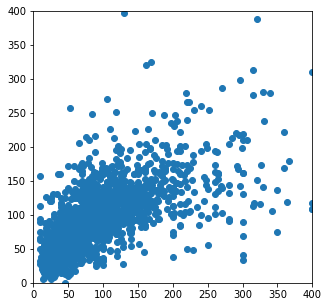

0.3990084145638428

In [127]:
fig=plt.figure()
X = listings_cleaned_final_prediction.drop(columns='price')
y = listings_cleaned_final_prediction['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,test_size=0.2)
categorical_features = ['host_is_superhost', 'property_type',]
transformer = ColumnTransformer([('ohe',OneHotEncoder(sparse=False),categorical_features)], remainder='passthrough')
pipeline_steps = [('preprocess', transformer),('scaler', StandardScaler()),('ml_model', xgb.XGBRegressor())]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train,y_train)



y_pred = pipe.predict(X_test)


fig, ax = plt.subplots(figsize =(5, 5))
plt.scatter(y_test,y_pred)
ax.set_xlim(xmin=0.0, xmax=400)
ax.set_ylim(ymin=0.0, ymax=400)

plt.show()

cross_validation_compas(pipe,X,y,scoring='r2')




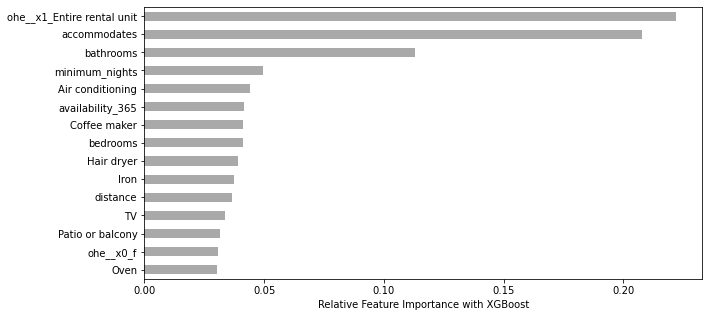

In [128]:

feat_importances = pd.Series(pipe.steps[2][1].feature_importances_, index=pipe.steps[0][1].get_feature_names())
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

In [143]:

from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'ml_model__n_estimators': [50, 100,150],
              'ml_model__learning_rate': [0.01, 0.05, 0.1], 
              'ml_model__max_depth': [3, 5, 10],
              'ml_model__colsample_bytree': [0.6, 0.7, 1],
             'ml_model__gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
grid = GridSearchCV(pipe, param_grid, cv=5,scoring = "r2",n_jobs=-1,return_train_score=True,verbose=4)
grid.fit(X_train, y_train)


# print best estimator parameters found during the grid search
print(grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 3/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=50;, score=(train=-0.385, test=-0.470) total time=   7.3s
[CV 5/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=100;, score=(train=0.113, test=0.098) total time=   7.1s
[CV 5/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=50;, score=(train=-0.379, test=-0.381) total time=   7.9s
[CV 3/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=30;, score=(train=-0.722, test=-0.869) total time=  11.2s
[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_esti

[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=30;, score=(train=-0.805, test=-0.755) total time=   5.7s
[CV 3/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=100;, score=(train=0.126, test=0.064) total time=   7.3s
[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=50;, score=(train=-0.370, test=-0.386) total time=   7.2s
[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=100;, score=(train=0.155, test=0.152) total time=  15.5s
[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=100;, score=(train=0.274, test=0.161) total time=  36.2s
[C

[CV 5/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=30;, score=(train=-0.804, test=-0.768) total time=   5.6s
[CV 5/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=50;, score=(train=-0.408, test=-0.396) total time=   3.9s
[CV 3/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=30;, score=(train=-0.753, test=-0.868) total time=   4.0s
[CV 3/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=50;, score=(train=-0.357, test=-0.455) total time=   7.4s
[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=30;, score=(train=-0.737, test=-0.787) total time=  11.5s

[CV 3/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=30;, score=(train=-0.773, test=-0.878) total time=   5.6s
[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=100;, score=(train=0.113, test=0.117) total time=   7.3s
[CV 5/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=30;, score=(train=-0.784, test=-0.758) total time=   4.3s
[CV 3/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=100;, score=(train=0.174, test=0.088) total time=  15.2s
[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=50;, score=(train=-0.318, test=-0.383) total time=  17.0s
[

[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=50;, score=(train=-0.401, test=-0.404) total time=   7.2s
[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=100;, score=(train=0.109, test=0.123) total time=   7.3s
[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=100;, score=(train=0.164, test=0.141) total time=  15.1s
[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=30;, score=(train=-0.752, test=-0.741) total time=  10.9s
[CV 2/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=100;, score=(train=0.272, test=0.186) total time=  36.5s
[

[CV 2/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=50;, score=(train=-0.401, test=-0.387) total time=   7.3s
[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=30;, score=(train=-0.770, test=-0.787) total time=   4.1s
[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=30;, score=(train=-0.785, test=-0.739) total time=   4.2s
[CV 2/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=100;, score=(train=0.158, test=0.165) total time=  15.4s
[CV 5/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=30;, score=(train=-0.752, test=-0.757) total time=  10.6s


[CV 1/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=30;, score=(train=-0.792, test=-0.799) total time=   5.5s
[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=3, ml_model__n_estimators=50;, score=(train=-0.410, test=-0.377) total time=   4.0s
[CV 2/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=30;, score=(train=-0.773, test=-0.772) total time=   4.1s
[CV 4/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=5, ml_model__n_estimators=50;, score=(train=-0.382, test=-0.357) total time=   7.9s
[CV 2/5] END ml_model__colsample_bytree=0.6, ml_model__gamma=0.0, ml_model__learning_rate=0.01, ml_model__max_depth=10, ml_model__n_estimators=30;, score=(train=-0.739, test=-0.772) total time=  11.3s

{'ml_model__colsample_bytree': 0.7, 'ml_model__gamma': 0.0, 'ml_model__learning_rate': 0.05, 'ml_model__max_depth': 10, 'ml_model__n_estimators': 100}


In [144]:
grid.score(X_test,y_test)

# predict
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

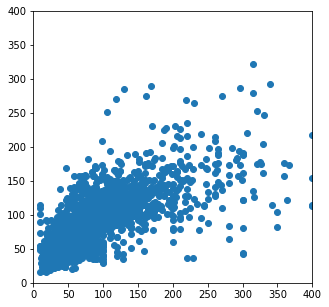

In [145]:
fig, ax = plt.subplots(figsize =(5, 5))
plt.scatter(y_test,y_pred_test)
ax.set_xlim(xmin=0.0, xmax=400)
ax.set_ylim(ymin=0.0, ymax=400)

plt.show()


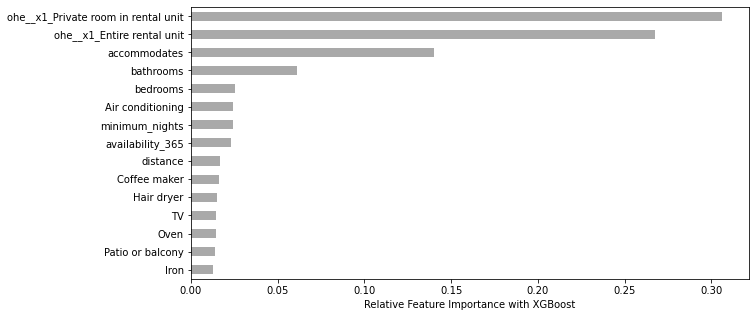

In [156]:
grid.score(X_test,y_test)

feat_importances = pd.Series(grid.best_estimator_.steps[2][1].feature_importances_, index=grid.best_estimator_.steps[0][1].get_feature_names())
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');